In [1]:
from IPython.display import clear_output

In [2]:
%pip install git+https://github.com/mwalmsley/galaxy_mnist.git
%pip install torch torchvision
!pip install xlsxwriter
clear_output()

In [3]:
!pip install 'qiskit[nature]'
!pip install qiskit[visualization]
!pip install qiskit-machine-learning
!pip install pylatexenc
clear_output()

In [4]:
# Qiskit Imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.tools.monitor import job_monitor
from qiskit.utils import QuantumInstance

In [5]:
# https://github.com/mwalmsley/galaxy_mnist
from galaxy_mnist import GalaxyMNISTHighrez
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd


from PIL import Image
import torchvision.transforms as transforms #Transforms are for common image transformations


from sklearn.decomposition import PCA
# scikit-learn Imports
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix



In [6]:
# for the training data
dataset_train = GalaxyMNISTHighrez(
    root='data_import/data',
    download=True,
    train=True  # by default True, or False for canonical test set
)
# for the testing data
dataset_test = GalaxyMNISTHighrez(
    root='data_import/data',
    download=True,
    train=False  # by default True, or False for canonical test set
)
#Train
images_train = dataset_train.data
labels_train = dataset_train.targets
#Test
images_test = dataset_test.data
labels_test = dataset_test.targets

In [7]:
GalaxyMNISTHighrez.classes

['smooth_round', 'smooth_cigar', 'edge_on_disk', 'unbarred_spiral']

   Where (as indicated in the first cell):
   - 0: `smooth_round`,
   - 1: `smooth_cigar`,
   - 2: `edge_on_disk`,
   - 3: `unbarred_spiral`

Next use numpy functions to summarize the number in each class

In [8]:
print(labels_train)
labels_trainNP = np.array(labels_train)
unique_labels, count_labels = np.unique(labels_trainNP, return_counts=True)
print("Label, count:", unique_labels, count_labels)

tensor([1, 1, 3,  ..., 3, 2, 0])
Label, count: [0 1 2 3] [1993 1994 1993 2020]


In [9]:
labels_testNP = np.array(labels_test)
unique_labels_test, count_labels_test = np.unique(labels_testNP, return_counts=True)
print("Label, count:", unique_labels_test, count_labels_test )

Label, count: [0 1 2 3] [507 506 507 480]


label: smooth_round


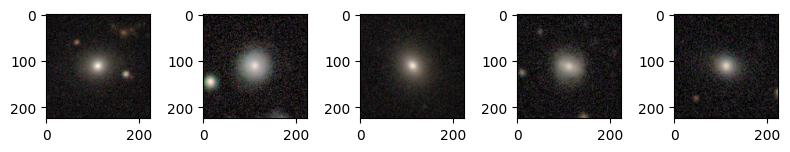

label: smooth_cigar


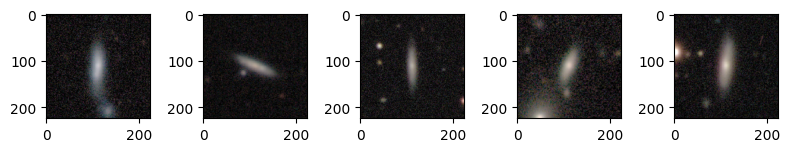

label: edge_on_disk


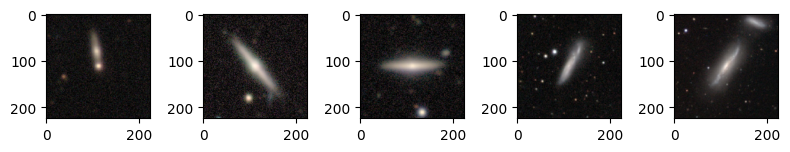

label: unbarred_spiral


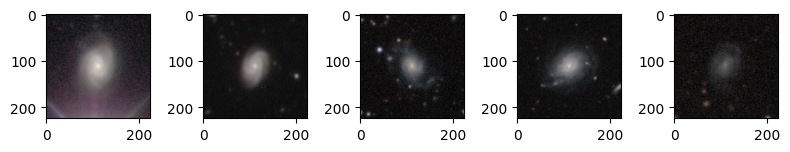

In [10]:
# Display nImage images for each class
nImage = 5
# Loop through classes
for j in range(len(GalaxyMNISTHighrez.classes)):
    fig = plt.figure(figsize=(8, 8))# Figure is 8 inches by 8 inches
    for i in range (nImage):    # Create images in each column
        train_image = images_train[(labels_train == j)][i]
        fig.add_subplot(1, nImage, i+1)
        plt.imshow(np.array(train_image).transpose(1, 2, 0))
    print("label: "+str(GalaxyMNISTHighrez.classes[j]))
    plt.tight_layout()
    plt.show()

---

### Data preprocessing

#### A. Grayscaling
We begin with conversion to grayscale, following this [tutorial](https://www.tutorialspoint.com/pytorch-how-to-convert-an-image-to-grayscale) from [tutorialspoint.com](https://www.tutorialspoint.com).

In [11]:
transformGrey = transforms.Grayscale()
images_trainGrey = transformGrey(images_train)

**Exercise 3:**
Display a set grayscale images for each classes (like the display of images above)

label: smooth_round


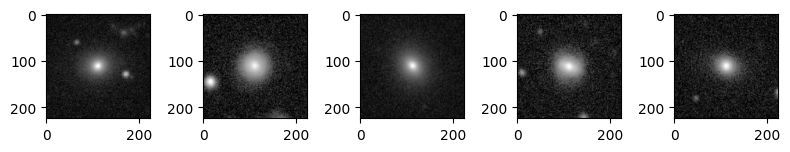

label: smooth_cigar


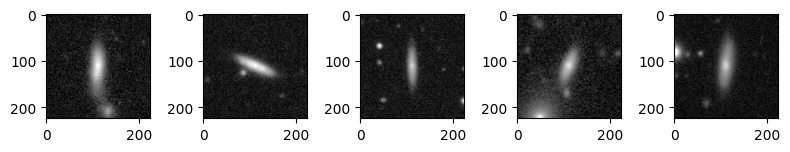

label: edge_on_disk


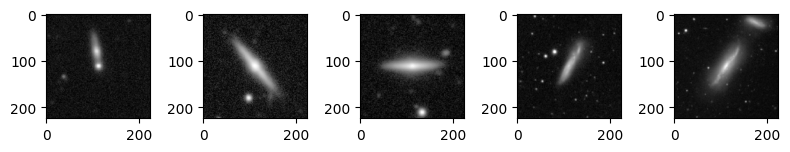

label: unbarred_spiral


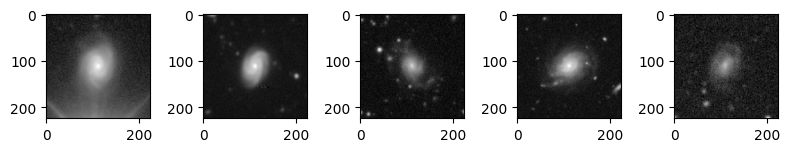

In [12]:
### -- Code here__
# Display nImage images for each class in grayscale
nImage = 5
# Loop through classes
for j in range(len(GalaxyMNISTHighrez.classes)):
    fig = plt.figure(figsize=(8, 8))# Figure is 8 inches by 8 inches
    for i in range (nImage):    # Create images in each column
        train_image = images_trainGrey[(labels_train == j)][i]
        fig.add_subplot(1, nImage, i+1)
        plt.imshow(np.array(train_image).transpose(1, 2, 0),cmap='gray')
    print("label: "+str(GalaxyMNISTHighrez.classes[j]))
    plt.tight_layout()
    plt.show()

We can notice that visually that nothing changed much from the original data. However, we reduced the complexity of the data by a favour of 3, which is enormous!

#### B. Image resizing  
(see  [this reference](https://www.tutorialspoint.com/pytorch-how-to-resize-an-image-to-a-given-size))

Reducing the size of the image can further reduce the complexity of the image data. However, we must be careful not to reduce so much as to removed distinctions between classes.

In [13]:
# Define the transform. The number in parenthesis gives number of pixels per side.
transformResize = transforms.Resize(56)

Now let's reduce the grayscale images:

In [14]:
images_trainResized = transformResize(images_trainGrey)

/home/jhonjc/anaconda3/envs/WOMANIUM/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Check the size again:

In [15]:
images_trainResized.shape

torch.Size([8000, 1, 56, 56])

**Exercise 4:**
Visualise the resized images for all classes

label: smooth_round


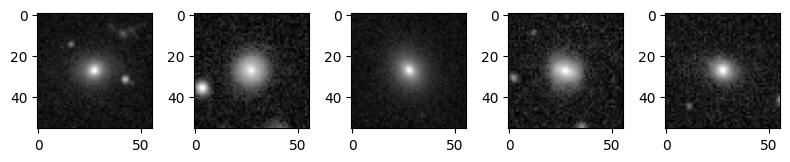

label: smooth_cigar


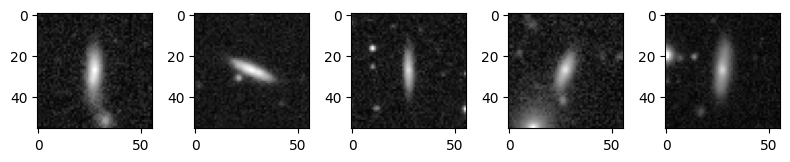

label: edge_on_disk


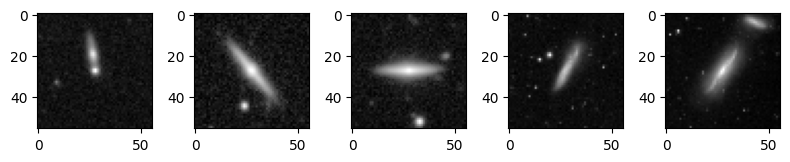

label: unbarred_spiral


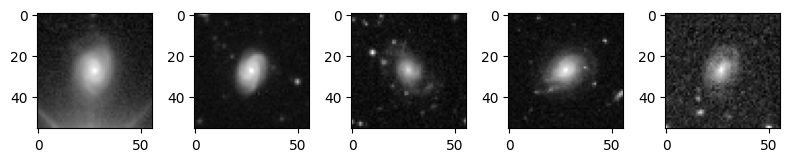

In [16]:
#___ Code here___
# Display nImage images for each class in grayscale
nImage = 5
# Loop through classes
for j in range(len(GalaxyMNISTHighrez.classes)):
    fig = plt.figure(figsize=(8, 8))# Figure is 8 inches by 8 inches
    for i in range (nImage):    # Create images in each column
        train_image = images_trainResized[(labels_train == j)][i]
        fig.add_subplot(1, nImage, i+1)
        plt.imshow(np.array(train_image).transpose(1, 2, 0), cmap='gray')
    print("label: "+str(GalaxyMNISTHighrez.classes[j]))
    plt.tight_layout()
    plt.show()


##### **_End of the pre-processing pipeline_**

Now the above pre-processing is not the only way where we can reduce the features, the following can also be done:
1. Cropping images away from the centre
2. Image segmentation, maybe to remove background noise (Deep learning can be used for this)
3. Explore ...

### Normalization

The pixel levels run from 0 to 255. If we divide by 255, we will put the levels within a standard scale of 0 to 1. Then they are suitable to use with other features that are similarly normalised. ([source](https://developers.google.com/machine-learning/data-prep/transform/normalization)).

In [17]:
images_trainPre = images_trainResized/255

Now let us check the values for one image before and after the nomalisation.

In [18]:
print("Pixel levels before normalization:")
print(images_trainResized[0][0][0])
print("Pixel levels after  normalization:")
print(images_trainPre[0][0][0])

Pixel levels before normalization:
tensor([24, 35, 16, 27, 11, 20,  7, 15, 15, 19, 14, 11,  5, 15, 37, 25, 17, 22,
        12, 22, 12,  6, 20,  5, 18, 15, 14, 31, 14, 12, 27, 18, 28, 22, 25, 17,
        25,  6,  5, 26, 22,  2, 14, 12, 14,  7, 16, 26, 12, 19, 13, 34, 36, 17,
        13, 20], dtype=torch.uint8)
Pixel levels after  normalization:
tensor([0.0941, 0.1373, 0.0627, 0.1059, 0.0431, 0.0784, 0.0275, 0.0588, 0.0588,
        0.0745, 0.0549, 0.0431, 0.0196, 0.0588, 0.1451, 0.0980, 0.0667, 0.0863,
        0.0471, 0.0863, 0.0471, 0.0235, 0.0784, 0.0196, 0.0706, 0.0588, 0.0549,
        0.1216, 0.0549, 0.0471, 0.1059, 0.0706, 0.1098, 0.0863, 0.0980, 0.0667,
        0.0980, 0.0235, 0.0196, 0.1020, 0.0863, 0.0078, 0.0549, 0.0471, 0.0549,
        0.0275, 0.0627, 0.1020, 0.0471, 0.0745, 0.0510, 0.1333, 0.1412, 0.0667,
        0.0510, 0.0784])


**Exercise 5**: Perform the preprocessing pipeline but on the testing set

In [19]:
#___ Code here___
images_testGrey = transformGrey(images_test)
print("Test Gray Scale: ",images_testGrey.shape)
images_testResized = transformResize(images_testGrey)
print("Test Gray Scale Resized: ", images_testResized.shape)
images_testPre = images_testResized/255
print("Pixel levels before normalization:")
print(images_testResized[0][0][0])
print("Pixel levels after  normalization:")
print(images_testPre[0][0][0])

Test Gray Scale:  torch.Size([2000, 1, 224, 224])
Test Gray Scale Resized:  torch.Size([2000, 1, 56, 56])
Pixel levels before normalization:
tensor([18, 30, 21, 14, 17, 27, 25, 36, 35, 19, 24, 21, 32, 18, 24, 15, 18, 10,
        19, 32, 30, 17, 21, 17, 25, 19, 13, 17, 21, 18, 26, 28, 16, 15, 41, 18,
        17, 30, 20, 16, 40, 14, 15, 17, 14, 15, 18, 20, 26, 25, 18, 22, 11, 17,
        17, 23], dtype=torch.uint8)
Pixel levels after  normalization:
tensor([0.0706, 0.1176, 0.0824, 0.0549, 0.0667, 0.1059, 0.0980, 0.1412, 0.1373,
        0.0745, 0.0941, 0.0824, 0.1255, 0.0706, 0.0941, 0.0588, 0.0706, 0.0392,
        0.0745, 0.1255, 0.1176, 0.0667, 0.0824, 0.0667, 0.0980, 0.0745, 0.0510,
        0.0667, 0.0824, 0.0706, 0.1020, 0.1098, 0.0627, 0.0588, 0.1608, 0.0706,
        0.0667, 0.1176, 0.0784, 0.0627, 0.1569, 0.0549, 0.0588, 0.0667, 0.0549,
        0.0588, 0.0706, 0.0784, 0.1020, 0.0980, 0.0706, 0.0863, 0.0431, 0.0667,
        0.0667, 0.0902])


In [20]:
images_trainPre.shape

torch.Size([8000, 1, 56, 56])

In [21]:
images_testPre.shape

torch.Size([2000, 1, 56, 56])

In [22]:
# aplanar las imágenes en un vector unidimensional
X_train = images_trainPre.reshape(8000, -1)
X_test = images_testPre.reshape(2000, -1)
labels_train = dataset_train.targets
labels_test = dataset_test.targets

In [23]:
def excel_export(report_dict,best_params,sheet_name,writer):
  df = pd.DataFrame(report_dict).transpose()
  df_mejor_valores = pd.DataFrame.from_dict(best_params, orient='index', columns=['Valor']).T
  df_final = pd.concat([df, df_mejor_valores], axis=1,ignore_index=False, keys=[str(best_params)])
  df_final.to_excel(writer, sheet_name=sheet_name)

In [24]:
type(labels_test)

torch.Tensor

In [25]:
"""
X_train = X_train[:100, :]
X_test = X_test[:100, :]

labels_train = labels_train[:100]
labels_test = labels_test[:100]

labels_train.shape
"""


'\nX_train = X_train[:100, :]\nX_test = X_test[:100, :]\n\nlabels_train = labels_train[:100]\nlabels_test = labels_test[:100]\n\nlabels_train.shape\n'

In [26]:
X_test.shape


torch.Size([2000, 3136])

In [30]:
pca_n_features = [6,7,8,9]
#GridSearch Parameters
C = [0.1,0.8,0.9,1,1.1,1.2,1.3,1.4]
kernel = ['linear', 'rbf']
gamma = [0.1,0.8,0.9,1,1.1,1.2,1.3,1.4]
param_grid = {'C': C,
               'kernel': kernel,
               'gamma': gamma,
             }

writer = pd.ExcelWriter('resultados_classic.xlsx', engine='xlsxwriter')

for numero_de_componentes in pca_n_features:
  pca = PCA(n_components=numero_de_componentes)
  # ajustar y transformar los datos de entrenamiento
  X_train_pca = pca.fit_transform(X_train)
  # transformar los datos de prueba
  X_test_pca = pca.transform(X_test)

  SVC_Model = SVC()
  rf_RandomGrid = RandomizedSearchCV(estimator = SVC_Model, param_distributions = param_grid, cv = 10, verbose=2, n_jobs = 4)
  rf_RandomGrid.fit(X_train_pca, labels_train)
  best_params = rf_RandomGrid.best_params_
  best_estimator = rf_RandomGrid.best_estimator_
  y_predict_classical = best_estimator.predict(X_test_pca)
  metric_report_classical =  classification_report(labels_test, y_predict_classical)
  report_dict = classification_report(labels_test, y_predict_classical, output_dict=True)
  excel_export(report_dict=report_dict,best_params=best_params, sheet_name="n_pca_{}".format(numero_de_componentes),writer=writer)
writer.close()


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END ....................C=1.1, gamma=1.4, kernel=linear; total time=   4.6s
[CV] END .......................C=0.9, gamma=1.2, kernel=rbf; total time=   2.1s
[CV] END .......................C=0.9, gamma=1.2, kernel=rbf; total time=   2.5s
[CV] END ....................C=0.1, gamma=1.3, kernel=linear; total time=   3.1s
[CV] END ....................C=0.1, gamma=1.3, kernel=linear; total time=   2.8s
[CV] END ....................C=0.1, gamma=1.3, kernel=linear; total time=   2.8s
[CV] END .........................C=1, gamma=0.8, kernel=rbf; total time=   2.1s
[CV] END .........................C=1, gamma=0.8, kernel=rbf; total time=   1.9s
[CV] END ....................C=1.1, gamma=1.1, kernel=linear; total time=   4.3s
[CV] END ....................C=1.1, gamma=1.1, kernel=linear; total time=   4.4s
[CV] END ....................C=1.1, gamma=1.1, kernel=linear; to

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END .......................C=0.9, gamma=1.2, kernel=rbf; total time=   2.4s
[CV] END .......................C=0.9, gamma=1.2, kernel=rbf; total time=   2.7s
[CV] END ....................C=0.1, gamma=1.3, kernel=linear; total time=   2.7s
[CV] END ....................C=0.1, gamma=1.3, kernel=linear; total time=   2.9s
[CV] END .........................C=1, gamma=0.8, kernel=rbf; total time=   2.1s
[CV] END .........................C=1, gamma=0.8, kernel=rbf; total time=   1.9s
[CV] END .........................C=1, gamma=0.8, kernel=rbf; total time=   1.9s
[CV] END ....................C=1.1, gamma=1.1, kernel=linear; total time=   4.6s
[CV] END ....................C=1.1, gamma=1.1, kernel=linear; total time=   4.7s
[CV] END .......................C=0.8, gamma=0.8, kernel=rbf; total time=   2.0s
[CV] END .......................C=0.8, gamma=0.8, kernel=rbf; total time=   2.0s
[CV] END .......................C=0.8, gamma=0

[CV] END .......................C=0.9, gamma=1.2, kernel=rbf; total time=   2.4s
[CV] END ....................C=0.1, gamma=1.3, kernel=linear; total time=   3.1s
[CV] END ....................C=0.1, gamma=1.3, kernel=linear; total time=   2.6s
[CV] END ....................C=0.1, gamma=1.3, kernel=linear; total time=   2.9s
[CV] END .........................C=1, gamma=0.8, kernel=rbf; total time=   2.1s
[CV] END .........................C=1, gamma=0.8, kernel=rbf; total time=   1.9s
[CV] END ....................C=1.1, gamma=1.1, kernel=linear; total time=   4.7s
[CV] END ....................C=1.1, gamma=1.1, kernel=linear; total time=   4.7s
[CV] END ....................C=1.1, gamma=1.1, kernel=linear; total time=   4.9s
[CV] END .......................C=0.8, gamma=0.8, kernel=rbf; total time=   1.8s
[CV] END .......................C=0.8, gamma=0.8, kernel=rbf; total time=   1.9s
[CV] END .......................C=1.3, gamma=1.2, kernel=rbf; total time=   2.1s
[CV] END ...................

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time=   4.9s
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time=   5.5s
[CV] END .......................C=0.8, gamma=1.3, kernel=rbf; total time=   2.9s
[CV] END .......................C=0.8, gamma=1.3, kernel=rbf; total time=   2.6s
[CV] END .......................C=0.8, gamma=1.3, kernel=rbf; total time=   2.8s
[CV] END .......................C=0.1, gamma=1.4, kernel=rbf; total time=   2.8s
[CV] END .......................C=0.1, gamma=1.4, kernel=rbf; total time=   2.6s
[CV] END .......................C=0.1, gamma=1.4, kernel=rbf; total time=   3.0s
[CV] END .......................C=1.1, gamma=1.2, kernel=rbf; total time=   3.1s
[CV] END .......................C=1.1, gamma=1.2, kernel=rbf; total time=   3.5s
[CV] END ....................C=1.3, gamma=0.1, kernel=linear; total time=   6.4s
[CV] END ....................C=1.3, gamma=0.1,

[CV] END .......................C=0.1, gamma=1.4, kernel=rbf; total time=   2.9s
[CV] END .......................C=0.1, gamma=1.4, kernel=rbf; total time=   2.8s
[CV] END .......................C=1.1, gamma=1.2, kernel=rbf; total time=   2.9s
[CV] END .......................C=1.1, gamma=1.2, kernel=rbf; total time=   3.6s
[CV] END .......................C=1.1, gamma=1.2, kernel=rbf; total time=   3.5s
[CV] END ....................C=1.3, gamma=0.1, kernel=linear; total time=   5.9s
[CV] END ....................C=1.3, gamma=0.1, kernel=linear; total time=   6.3s
[CV] END ......................C=1, gamma=1.2, kernel=linear; total time=   4.6s
[CV] END ......................C=1, gamma=1.2, kernel=linear; total time=   5.7s
[CV] END ......................C=1, gamma=1.2, kernel=linear; total time=   4.5s
[CV] END ....................C=1.2, gamma=1.1, kernel=linear; total time=   4.8s
[CV] END ....................C=1.2, gamma=1.1, kernel=linear; total time=   5.3s
[CV] END ...................

In [28]:
#Parte cuantica

In [29]:
X_train = images_trainPre.reshape(8000, -1)
X_test = images_testPre.reshape(2000, -1)
labels_train = dataset_train.targets
labels_test = dataset_test.targets

In [30]:
"""
X_train = X_train[:1000, :]
X_test = X_test[:1000, :]

labels_train = labels_train[:1000]
labels_test = labels_test[:1000]
"""
labels_train.shape


torch.Size([8000])

In [31]:
X_train.shape

torch.Size([8000, 3136])

In [32]:
# Definir la instancia cuántica
quantum_instance = QuantumInstance(Aer.get_backend('statevector_simulator'))

C:\Users\User\AppData\Local\Temp\ipykernel_53544\284496480.py:2: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(Aer.get_backend('statevector_simulator'))


In [33]:
def new_feature_map(feature_dimension, repeats = 1):
  """
  Feature function that encoding the classical data to quantum states
  This function is to use with the qiskit functions
  Args:
      repeats (int): Number of repetitions of the quantum circuit
  Returns:
      The qiskit circuit
  """
  qubits = feature_dimension #Number of features (columns) of the training data

  x = ParameterVector('x', length=qubits)
  var_custom = QuantumCircuit(qubits)

  for _ in range(repeats):
      for i in range(qubits):
          var_custom.rx(x[i], i)
      for i in range(qubits):
          for j in range(i + 1, qubits):
              var_custom.cx(i, j)
              var_custom.p(x[i] * x[j], j)
              var_custom.cx(i, j)
      var_custom.barrier()
            
  return var_custom

In [34]:
pca_n_features = [6,7,8,9]

#GridSearch Parameters
C = [0.1, 0.8, 0.9, 1, 1.2, 1.3, 1.4]
gamma = [0.01, 0.9, 1, 1.2, 1.4, 1.5]
param_grid = {'C': C,
               'gamma': gamma,
             }

writer = pd.ExcelWriter('resultados_quantum.xlsx', engine='xlsxwriter')

for numero_de_componentes in pca_n_features:
  pca = PCA(n_components=numero_de_componentes)
  # ajustar y transformar los datos de entrenamiento
  X_train_pca = pca.fit_transform(X_train)
  # transformar los datos de prueba
  X_test_pca = pca.transform(X_test)

  
  feature_maps = [
    ZZFeatureMap(feature_dimension=numero_de_componentes, reps=2),
    ZFeatureMap(feature_dimension=numero_de_componentes, reps=2),
    new_feature_map(feature_dimension=numero_de_componentes, repeats = 1)
  ]
  SVC_Model = SVC(kernel='precomputed')

  for feature_map in feature_maps:
    # Calcular la matriz de kernel cuántico
    custom_kernel_v1 = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance)

    kernel_train = custom_kernel_v1.evaluate(x_vec=X_train_pca)
    kernel_test = custom_kernel_v1.evaluate(x_vec=X_test_pca, y_vec=X_train_pca)

    # Realizar la búsqueda de cuadrícula
    rf_RandomGrid = RandomizedSearchCV(estimator = SVC_Model, param_distributions = param_grid, cv = 5, verbose=2, n_jobs = 4,n_iter=10)
    rf_RandomGrid.fit(kernel_train, labels_train)

    best_params = rf_RandomGrid.best_params_
    best_estimator = rf_RandomGrid.best_estimator_
    y_predict_classical = best_estimator.predict(kernel_test)
    metric_report_classical =  classification_report(labels_test, y_predict_classical)
    report_dict = classification_report(labels_test, y_predict_classical, output_dict=True)
    excel_export(report_dict=report_dict,best_params=best_params, sheet_name="{}_n_pca_{}".format(type(feature_map).__name__, numero_de_componentes),writer=writer)
writer.save()


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


---